In [1]:
# Importing required packages
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import jax.numpy as jnp
from iminuit import Minuit 
from src.model import*
from numpyro.infer import NUTS, MCMC
import jax
from src.model import*
from numpyro.infer import NUTS, MCMC

/root/Document/Term2/S2/S2_Cw/s2_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Importing data on Antikythera Mechanism (AM) as data_AM
data_AM = pd.read_csv("data/1-Fragment_C_Hole_Measurements.csv")

# Printing data
data_AM  

,Section ID,Hole,Inter-hole Distance,Mean(X),Mean(Y)
0,0,1,NaN,15.59931,92.59653
1,1,2,NaN,16.44167,91.50069
2,1,3,1.440694,17.30764,90.34931
3,1,4,1.456973,18.15278,89.16250
4,1,5,1.299821,18.96528,88.14792
...,...,...,...,...,...
76,7,77,1.259985,108.69444,63.42778
77,7,78,1.430105,110.05486,63.86875
78,7,79,1.179606,111.14583,64.31736
79,7,80,1.428043,112.48021,64.82604


In [3]:
sub_data = data_AM[~data_AM['Section ID'].isin([0,4])] # removing sections 0 and 4
sub_data.shape # Quick check

(79, 5)

HMC

In [4]:
hole_d, x_d, y_d = jnp.array(sub_data['Hole'].to_numpy()), jnp.array(sub_data['Mean(X)'].to_numpy()), jnp.array(sub_data['Mean(Y)'].to_numpy())

sec_id_sub = sub_data['Section ID'].to_numpy()
sec_mod = jnp.array([x-1 if x < 4 else x - 2 for x in sec_id_sub]) 

Radial-tangential

In [5]:
nuts_kernel_rt = NUTS(rad_tang_model)

mcmc_rt = MCMC(nuts_kernel_rt, num_samples=2000, num_warmup=1000)
rng_key = jax.random.key(0)
mcmc_rt.run(rng_key, sec_mod, hole_d, x_obs = x_d, y_obs = y_d)

posterior_samples_rt = mcmc_rt.get_samples()

sample: 100%|██████████| 3000/3000 [03:34<00:00, 14.02it/s, 511 steps of size 8.75e-03. acc. prob=0.95] 


In [6]:
mcmc_rt.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
            N    355.22      1.39    355.23    352.82    357.34    398.10      1.00
alpha_pred[0]     -2.54      0.00     -2.54     -2.55     -2.54    584.05      1.00
alpha_pred[1]     -2.54      0.00     -2.54     -2.55     -2.54    803.22      1.00
alpha_pred[2]     -2.54      0.00     -2.54     -2.55     -2.53    403.25      1.00
alpha_pred[3]     -2.56      0.02     -2.56     -2.58     -2.53   1267.74      1.00
alpha_pred[4]     -2.55      0.03     -2.55     -2.60     -2.50    913.67      1.00
alpha_pred[5]     -2.58      0.01     -2.58     -2.59     -2.57    638.84      1.00
            r     77.33      0.28     77.33     76.87     77.78    387.22      1.00
      sigma_r      0.03      0.00      0.03      0.02      0.03   1575.85      1.00
      sigma_t      0.13      0.01      0.13      0.11      0.15   2090.16      1.00
  x_centre[0]     79.69      0.20     79.69     79.34     79.99    421.77  

In [9]:
N_rt_pred = jnp.mean(posterior_samples_rt['N'])
R_rt_pred = jnp.mean(posterior_samples_rt['r'])

num_sections = 6  # Assuming 6 sections

phases_opt_rt = jnp.mean(posterior_samples_rt["alpha_pred"], axis=0)
xcents_opt_rt = jnp.mean(posterior_samples_rt["x_centre"], axis=0)
ycents_opt_rt = jnp.mean(posterior_samples_rt["y_centre"], axis=0)

# Store all extracted parameters in a structured array
optimised_params_rt = jnp.array([phases_opt_rt, xcents_opt_rt, ycents_opt_rt])

In [24]:
nuts_kernel_is = NUTS(isotropic_model)

mcmc_iso = MCMC(nuts_kernel_is, num_samples=2000, num_warmup=1000)
rng_key_iso = jax.random.key(0)
mcmc_iso.run(rng_key_iso, sec_mod, hole_d, x_obs = x_d, y_obs = y_d)

posterior_samples_iso = mcmc_iso.get_samples()

sample: 100%|██████████| 3000/3000 [00:53<00:00, 56.36it/s, 319 steps of size 9.25e-03. acc. prob=0.87] 


In [10]:
N_is_pred = jnp.mean(posterior_samples_iso['N'])
R_is_pred = jnp.mean(posterior_samples_iso['r'])

num_sections = 6  # Assuming 6 sections

phases_opt_iso = jnp.mean(posterior_samples_iso["alpha_pred"], axis=0)
xcents_opt_iso = jnp.mean(posterior_samples_iso["x_centre"], axis=0)
ycents_opt_iso = jnp.mean(posterior_samples_iso["y_centre"], axis=0)

# Store all extracted parameters in a structured array
optimised_params_iso = jnp.array([phases_opt_iso, xcents_opt_iso, ycents_opt_iso])

In [8]:
mcmc_iso.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
            N    355.78      4.29    355.82    348.27    362.11    352.95      1.00
alpha_pred[0]     -2.54      0.00     -2.54     -2.55     -2.54    533.23      1.00
alpha_pred[1]     -2.54      0.01     -2.54     -2.56     -2.52    778.70      1.00
alpha_pred[2]     -2.54      0.01     -2.54     -2.56     -2.52    358.19      1.00
alpha_pred[3]     -2.56      0.04     -2.56     -2.61     -2.49    858.00      1.00
alpha_pred[4]     -2.55      0.04     -2.55     -2.61     -2.48    692.75      1.00
alpha_pred[5]     -2.58      0.02     -2.58     -2.62     -2.54    510.25      1.00
            r     77.46      0.92     77.47     75.97     78.97    353.68      1.00
        sigma      0.09      0.01      0.09      0.09      0.10   1791.44      1.00
  x_centre[0]     79.76      0.66     79.76     78.74     80.85    377.59      1.00
  x_centre[1]     79.97      0.76     79.95     78.67     81.14    790.07  

In [25]:
# Computing hole predicted location using predicted parameters from Iminuit for:

# Radial-Tangential Model:
predicted_hole_loc_rt = hole_prediction(N_rt_pred, R_rt_pred, optimised_params_rt, sec_mod)

# Isotropic Model:
predicted_hole_loc_is = hole_prediction(N_is_pred, R_is_pred, optimised_params_iso, sec_mod)

In [26]:
# Constructiong Data Frame for:

# Radial-Tangential Model

d_rt = {

    'Section ID' : sub_data['Section ID'].to_numpy(),
    'Hole' : sub_data['Hole'].to_numpy(),
    'Mean(X)' : predicted_hole_loc_rt[0],
    'Mean(Y)' : predicted_hole_loc_rt[1]
}

pred_data_rt_HMC = pd.DataFrame(d_rt)

# Radial-Tangential Model

d_is = {

    'Section ID' : sub_data['Section ID'].to_numpy(),
    'Hole' : sub_data['Hole'].to_numpy(),
    'Mean(X)' : predicted_hole_loc_is[0],
    'Mean(Y)' : predicted_hole_loc_is[1]
}

pred_data_is_HMC = pd.DataFrame(d_is)

/tmp/ipykernel_21181/327035939.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(sub_data["Section ID"].unique()))


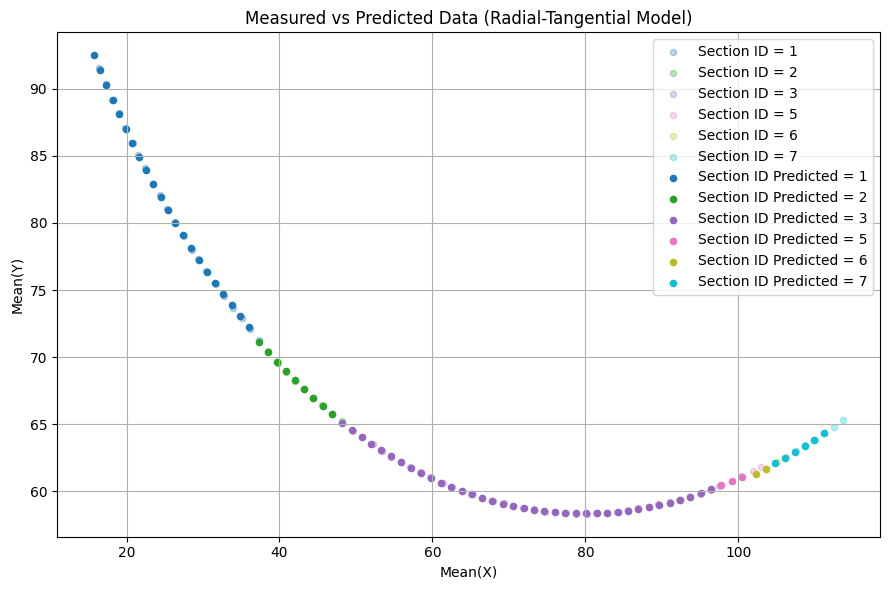

In [27]:
# Define colors using a colormap
colors = plt.cm.get_cmap("tab10", len(sub_data["Section ID"].unique()))

# Plot
plt.figure(figsize=(9, 6))

# Loop through each section and plot automatically
# Selecting different region based on Section ID
for i, (section, data) in enumerate(sub_data.groupby("Section ID")):
    plt.scatter(data["Mean(X)"], data["Mean(Y)"], s=20, alpha = 0.3, color=colors(i), label=f"Section ID = {section}")

for i, (section, data) in enumerate(pred_data_is_HMC.groupby("Section ID")):
    plt.scatter(data["Mean(X)"], data["Mean(Y)"], s=20, color=colors(i), label=f"Section ID Predicted = {section}")

# Add labels and title
plt.xlabel('Mean(X)')
plt.ylabel('Mean(Y)')
plt.title('Measured vs Predicted Data (Radial-Tangential Model)')

# Invert y-axis for better visualization (resemble ring shape)
#plt.gca().invert_yaxis()

# Add legend, adjust layout and grid
plt.legend()
plt.tight_layout()
plt.grid()

# Show plot
plt.show()

In [ ]:
def plotting_comparison(observed_holes, predicted_holes, text_model):

    """
    Plots a comparison between measured (observed) and predicted hole positions 
    for different sections of the Antikythera mechanism.

    This function generates a scatter plot where the measured hole positions 
    are displayed with a semi-transparent color, while the predicted positions 
    are overlaid in a solid color. The section IDs are used to differentiate 
    points using distinct colors.

    Parameters
    ----------
    observed_holes : pandas.DataFrame
        A DataFrame containing observed (measured) hole positions with at least the 
        following columns:
        - "Mean(X)": The x-coordinates of the measured positions.
        - "Mean(Y)": The y-coordinates of the measured positions.
        - "Section ID": The section identifier for each hole.

    predicted_holes : pandas.DataFrame
        A DataFrame containing predicted hole positions with the same structure as 
        `observed_holes`, representing the model's inferred positions.

    text_model : str
        A string representing the name of the model being evaluated. It is used in 
        the plot title to indicate which model's predictions are being compared.

    Returns
    -------
    None
        Displays a scatter plot showing the comparison of measured vs predicted 
        hole positions.

    Notes
    -----
    - Different sections are represented with unique colors from the `tab10` colormap.
    - The predicted positions are labeled separately to distinguish them from the 
      measured data.
    - The y-axis inversion (commented) can be activated if needed for a better 
      visualization resembling a ring shape.

    Example
    -------

    >>> plotting_comparison(sub_data, pred_data_rt_HMC, 'Radial-Tangential Model')


    This will generate a scatter plot comparing observed and predicted hole positions 
    for the Radial-Tangential Model.
    """

    # Define colors using a colormap
    colors = plt.cm.get_cmap("tab10", len(observed_holes["Section ID"].unique()))

    # Plot
    plt.figure(figsize=(9, 6))

    # Loop through each section and plot automatically
    # Selecting different region based on Section ID
    for i, (section, data) in enumerate(observed_holes.groupby("Section ID")):
        plt.scatter(data["Mean(X)"], data["Mean(Y)"], s=20, alpha = 0.3, color=colors(i), label=f"Section ID = {section}")

    for i, (section, data) in enumerate(predicted_holes.groupby("Section ID")):
        plt.scatter(data["Mean(X)"], data["Mean(Y)"], s=20, color=colors(i), label=f"Section ID Predicted = {section}")

    # Add labels and title
    plt.xlabel('Mean(X)')
    plt.ylabel('Mean(Y)')
    plt.title(f'Measured vs Predicted Data ({text_model})')

    # Invert y-axis for better visualization (resemble ring shape)
    # plt.gca().invert_yaxis()

    # Add legend, adjust layout and grid
    plt.legend()
    plt.tight_layout()
    plt.grid()

    # Show plot
    plt.show()

/tmp/ipykernel_21181/1902193499.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(observed_holes["Section ID"].unique()))


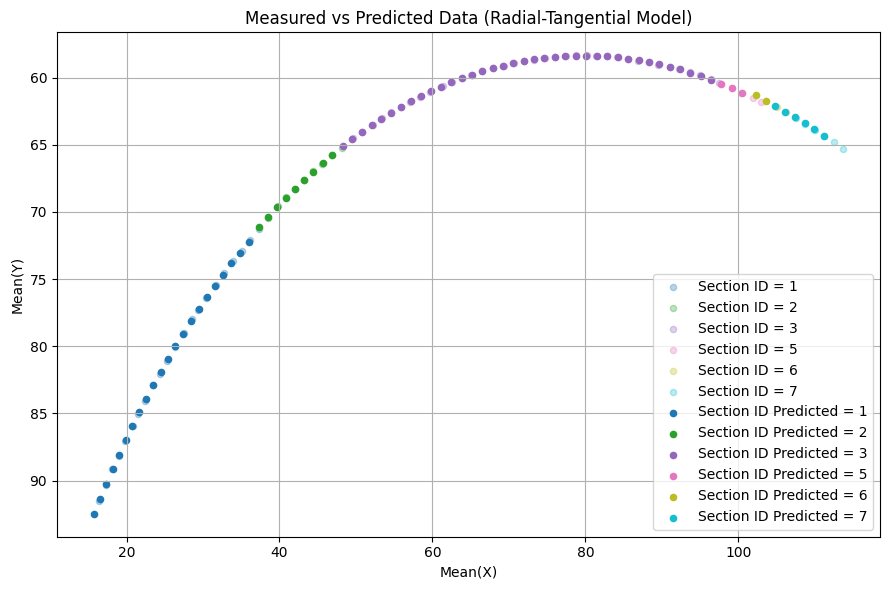

In [19]:
plotting_comparison(sub_data, pred_data_rt_HMC, 'Radial-Tangential Model')

In [14]:
text_model = 'Model'
print(f'model is {text_model}')

model is Model


In [ ]:
def visualise_data(df_data):

    """
    Visualizes the hole locations from the given dataset, grouping them by section ID.

    This function generates a scatter plot where each section's holes are represented 
    using distinct colors. The function automatically assigns colors based on section 
    IDs and plots the hole positions on a 2D plane.

    Parameters
    ----------
    df_data : pandas.DataFrame
        A DataFrame containing hole position data with at least the following columns:
        - "Mean(X)": The x-coordinates of the hole positions.
        - "Mean(Y)": The y-coordinates of the hole positions.
        - "Section ID": The section identifier for each hole.

    Returns
    -------
    None
        Displays a scatter plot showing the spatial distribution of hole positions 
        grouped by section.

    Notes
    -----
    - Different sections are represented with unique colors from the `tab10` colormap.
    - The function automatically iterates over unique section IDs for visualization.
    - The y-axis inversion (commented) can be enabled if needed to better resemble 
      the actual structure of the ring.

    Example
    -------

    >>> visualise_data(df_hole_positions)


    This will generate a scatter plot showing the hole locations categorized by section.
    """

    # Define colors using a colormap
    colors = plt.cm.get_cmap("tab10", len(df_data["Section ID"].unique()))

    # Plot
    plt.figure(figsize=(9, 6))

    # Loop through each section and plot automatically
    # Selecting different region based on Section ID
    for i, (section, data) in enumerate(df_data.groupby("Section ID")):
        plt.scatter(data["Mean(X)"], data["Mean(Y)"], s=20, color=colors(i), label=f"Section ID = {section}")

    # Add labels and title
    plt.xlabel('Mean(X)')
    plt.ylabel('Mean(Y)')
    plt.title('Visualisation of Holes Location')

    # Invert y-axis for better visualization (resemble ring shape)
    #plt.gca().invert_yaxis()

    # Add legend, adjust layout and grid
    plt.legend()
    plt.tight_layout()
    plt.grid()

    # Show plot
    plt.show()

/tmp/ipykernel_21181/1575899975.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(df_data["Section ID"].unique()))


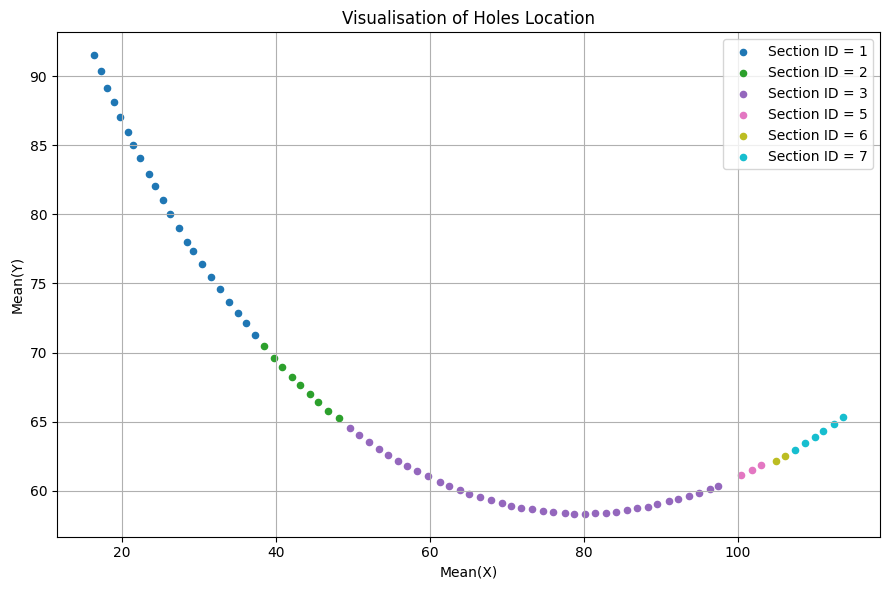

In [23]:
visualise_data(sub_data)